In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math

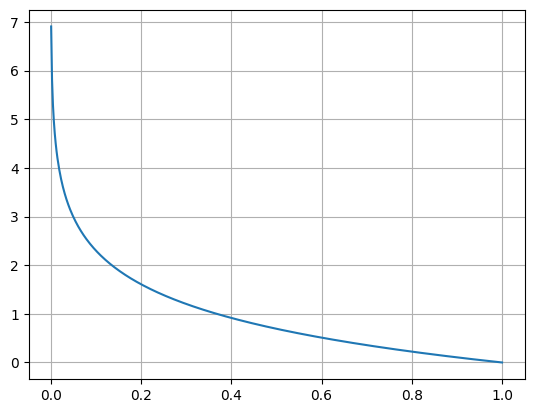

In [25]:
D = np.linspace(.001,1,500)
plt.plot(
    D,
    [math.log(1/x) for x in D],
)
plt.grid(True)